## Failure ratio of master jobs
Jobs initiated in the last 24h

In [1]:
%matplotlib inline
import sys
import os
import datetime
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
oneDayAgo = (datetime.datetime.now() - datetime.timedelta(days=1)).isoformat()

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(oneDayAgo)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

last_builds = pd.DataFrame(
    df
        .sort_values(by='stage_timestamp')
        .drop_duplicates('job_name', keep='last')
)

In [6]:
total_rows = len(last_builds)
successes = len(last_builds.loc[df['current_build_current_result'] == 'SUCCESS'])
failures = len(last_builds.loc[df['current_build_current_result'] == 'FAILURE'])
aborted = len(last_builds.loc[df['current_build_current_result'] == 'ABORTED'])
unknows = total_rows - successes - failures - aborted
success_ratio = round(successes/total_rows * 100)

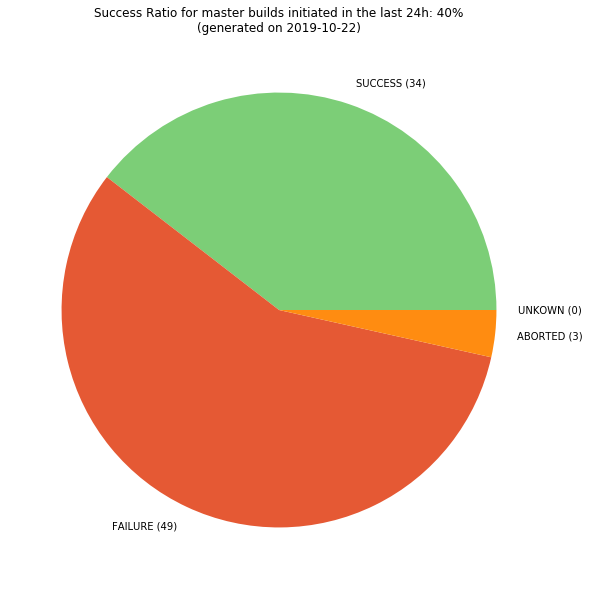

In [14]:
statuses = [successes, failures, aborted, unknows]
labels = ['SUCCESS',
          'FAILURE',
          'ABORTED',
          'UNKOWN']

colors = {
    'ABORTED': '#FF8C11',
    'FAILURE': '#E55934',
    'SUCCESS': '#7CCE77',
    'UNKOWN':  '#CCCCCC'
}

labels_with_amounts = list(
    map(
        lambda status, label: '{0} ({1})'.format(status, label),
        labels,
        statuses
    )
)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.pie(statuses, labels=labels_with_amounts, colors=[ colors[label] for label in labels ])
ax.set_title('Success Ratio for master builds initiated in the last 24h: {0}%\n(generated on {1})'.format(success_ratio, datetime.date.today()))
plt.show()